# Setup

This process is loosely based on this article: https://towardsdatascience.com/beyond-classification-with-transformers-and-hugging-face-d38c75f574fb

Attaching google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
project_path = ('/content/gdrive/My Drive/DATA_690_NLP/Text_Summarization/')
sys.path.append(project_path)

Mounted at /content/gdrive/


Installing hugging face package

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 14.0MB/s 
     |████████████████████████████████| 3.3MB 67.5MB/s 
     |████████████████████████████████| 901kB 46.4MB/s 


Importing necessary packages

In [3]:
import torch
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel, BertTokenizer
import seaborn as sns
sns.set()
% matplotlib inline
np.random.seed(42);

Load data

In [4]:
articles_df = pd.read_csv(f'{project_path}Data/processed/Clean_Lemma_LongForm_Telehealth.csv')
articles_df.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\r\n\r\ntelepsychology, meta-analysis...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,36423,veteran face a variety of stressor relate to t...,veteran face a variety of stressor relate time...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,KEYWORDS:\r\n\r\nremote child custody evaluati...,"Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the chi...,72009,the impact of the covid-19 pandemic on the chi...,the impact of the covid-19 pandemic on the chi...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\r\n\r\nforensic e-mental health, tel...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highl...,61640,"in November 2019 , covid-19 — the infectious ,...","in November 2019 , covid-19 — the infectious ,...",Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\r\n\r\neducation and training, telep...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,29392,anxiety and depressive disorder be among the m...,anxiety and depressive disorder be among the m...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\r\n\r\nremote psychotherapy, Covid-1...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,In mid-March 2020 the authors—as well as the m...,41383,"in mid - March , 2020 , the author — as well a...","in mid - March , 2020 , the author — as well a...",Covid


# Calculating Vector Representations for each Article

The idea here is to run each article through a pre-trained BERT model (https://huggingface.co/bert-base-uncased) that has been trained on massive amounts of data (https://yknzhu.wixsite.com/mbweb and https://en.wikipedia.org/wiki/English_Wikipedia). So the model already "knows" a lot about the structure of the English language, and this knowledge will be used to create a numerical representation of each article.

Because the articles are too long to input into the model, they had to be split into $p$ number of sentences. Each sentence output is represented by a matrix $S$ such that $S \in \mathbb{R}^{m \times n}$, where $m$ is the number of tokens in the sentence and $n$ is the number of features for each token. And then a vector is created to represent each sentence, by calculating the mean of each column:

$$
  s = S^T (mJ)^{-1}
$$

Where $J$ is a matrix of ones of dimensions $m \times 1$.

The vectors for each sentence then form a matrix representation of an article:

$$
A = (s^T_0\dots s^T_p)
$$

Where $A \in \mathbb{R}^{p \times n}$

And in order to create a vector representation of the entire article, the mean for each colum of the article matrix is calculated to create such vector:

$$
  a = A^T (pJ)^{-1}
$$

And the collection of this article vectors create a matrix representation of the set of artcles.

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import textwrap

def calculate_latent_space(articles):

  model_name = "bert-base-uncased"
  TOTAL_NO_LAYERS = 12
  TOTAL_NO_ATTEN_HEADS = 12
  CMAP = sns.light_palette("blue")
  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  config = BertConfig.from_pretrained(model_name, output_attentions=True)
  bert_model = BertModel.from_pretrained(model_name, config=config)
  bert_model.eval()
  bert_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

  article_vectors = []

  with torch.no_grad():
    for article in articles:

      #sentence_tokens = sent_tokenize(article)

      # sentence_tokens = textwrap.wrap(article, 512)

      word_tokens = word_tokenize(article)

      max_sentence_length = 50
      sentence_tokens = [word_tokens[i * max_sentence_length:(i + 1) * max_sentence_length] for i in range((len(word_tokens) + max_sentence_length - 1) // max_sentence_length )]
      sentence_vectors = []

      for index, sentence in enumerate(sentence_tokens):
        tokens = bert_tokenizer(' '.join(sentence), return_tensors='pt', return_attention_mask=True).to(device)
        bert_model.to(device)
        output = bert_model(tokens.input_ids)

        sentence_matrix_representation = output.last_hidden_state.to('cpu').detach().numpy()[0]
        matrix_mean = np.mean(sentence_matrix_representation, axis=0).reshape((1, sentence_matrix_representation.shape[1]))
        sentence_vectors.append(matrix_mean)
        
      article_matrix_representation = np.array(sentence_vectors)
      article_matrix_representation = article_matrix_representation.reshape((article_matrix_representation.shape[0], article_matrix_representation.shape[2]))
      article_vector = np.mean(article_matrix_representation, axis=0)
      article_vector = article_vector.reshape((1, article_vector.shape[0]))
      article_vectors.append(article_vector)

  article_vectors = np.array(article_vectors)
  article_vectors = article_vectors.reshape((article_vectors.shape[0], article_vectors.shape[2]))
  print(article_vectors.shape)
  return article_vectors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Dimmensionality reduction

In order to be able to visualize the articles on a 2D Cartesian plane, this function does dimmensionality reduction using PCA (Principal Component Analysis) and t-SNE (t-distributed Stochastic Neighbor Embedding).

It also creates classes (clusters) using DBSCAN taking the results from each method.

I tried different values for ϵ, which determines the distance between to dots to be considered as the same cluster, and settled for the default values you see in the function signature.

I also tried different metrics, including cityblock, cosine, L1, L2, and manhattan. But decided to go with euclidean.



In [6]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

def calculate_clustering(
    article_vectors,
    prefix='raw',
    clustering_df=None,
    pca_eps=0.45,
    perplexity=7,
    tsne_eps=50
    ):

  # PCA
  pca = PCA(n_components=2)
  components_matrix = pca.fit_transform(article_vectors)

  if clustering_df is None:
    clustering_df = df = pd.DataFrame({f'{prefix}_component_1': components_matrix[:,0], '{prefix}_component_2': components_matrix[:,1]})
  else:
    clustering_df[f'{prefix}_pca_component_1'] = components_matrix[:,0]
    clustering_df[f'{prefix}_pca_component_2'] = components_matrix[:,1]
  
  pca_dbscan_clusters = DBSCAN(eps=pca_eps, metric='euclidean').fit_predict(components_matrix)
  clustering_df[f'{prefix}_pca_dbscan_class'] = pca_dbscan_clusters
  
  # t-SNE
  embedded_matrix = TSNE(n_components=2, perplexity=perplexity).fit_transform(article_vectors)

  clustering_df[f'{prefix}_tsne_dim_1'] = embedded_matrix[:,0]
  clustering_df[f'{prefix}_tsne_dim_2'] = embedded_matrix[:,1]

  tsne_dbscan_clusters = DBSCAN(eps=tsne_eps, metric='euclidean').fit_predict(embedded_matrix)
  clustering_df[f'{prefix}_tsne_dbscan_class'] = tsne_dbscan_clusters

  return clustering_df

# Clustering Analysis

Run the BERT model on text that has been cleaned, lemmatized, and lemmatized with abbreviations in long form.

In [7]:
cleaned_article_vectors = calculate_latent_space(articles_df['Clean_Content'].values)
cleaned_article_vectors_df = pd.DataFrame(cleaned_article_vectors)
cleaned_article_vectors_df.to_csv(f'{project_path}/Data/cleaned_articles_latent_space.csv')
del cleaned_article_vectors_df
lemma_article_vectors = calculate_latent_space(articles_df['Clean_Content_Lemma'].values)
lemma_article_vectors_df = pd.DataFrame(lemma_article_vectors)
lemma_article_vectors_df.to_csv(f'{project_path}/Data/lemma_articles_latent_space.csv')
del lemma_article_vectors_df
lemma_lg_article_vectors = calculate_latent_space(articles_df['Clean_Content_Lemma_LongForm'].values)
lemma_lg_article_vectors_df = pd.DataFrame(lemma_lg_article_vectors)
lemma_lg_article_vectors_df.to_csv(f'{project_path}/Data/lemma_lg_articles_latent_space.csv')
del lemma_lg_article_vectors_df


(44, 768)
(44, 768)
(44, 768)


Get the clustering results.

In [34]:
results_df = pd.DataFrame()
results_df['year'] = pd.to_numeric(articles_df['Date Published'])
results_df['class'] = results_df['year'].apply(lambda x: 'pre-pandemic' if x < 2020 else 'post-pandemic')
results_df = calculate_clustering(
    cleaned_article_vectors,
    prefix='cleaned',
    clustering_df=results_df,
    pca_eps=0.47,
    perplexity=9,
    tsne_eps=48
    )
results_df = calculate_clustering(
    lemma_article_vectors,
    prefix='lemma',
    clustering_df=results_df,
    pca_eps=0.40,
    perplexity=7,
    tsne_eps=55
    )
results_df = calculate_clustering(
    lemma_lg_article_vectors,
    prefix='lemma_lg',
    clustering_df=results_df,
    pca_eps=0.38,
    perplexity=10,
    tsne_eps=30
    )

## PCA Results

Plot showing results color coded by pre and post pandemic publication date.

### Cleaned text

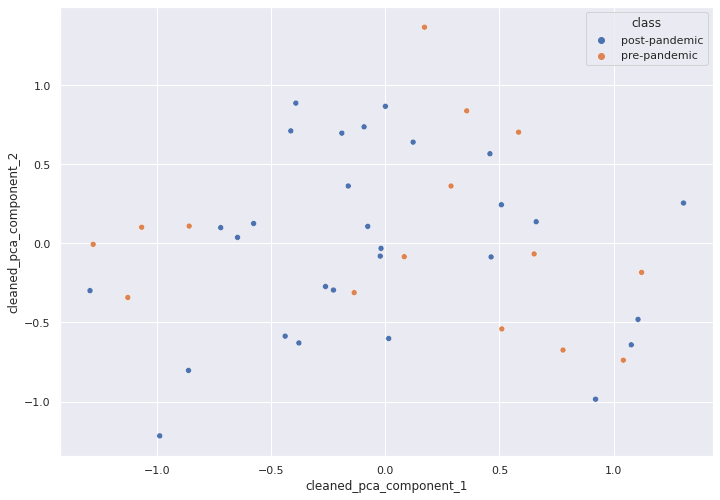

In [35]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='cleaned_pca_component_1', y='cleaned_pca_component_2', hue='class', ax=ax)

### Lemmatized text

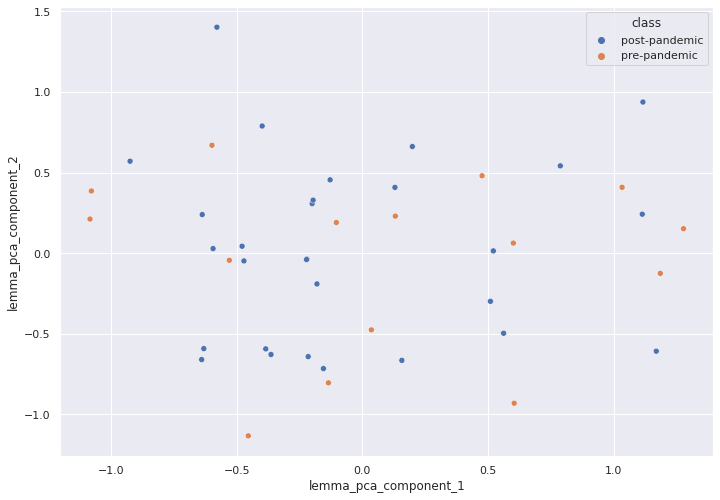

In [36]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_pca_component_1', y='lemma_pca_component_2', hue='class', ax=ax)

### Lemmatized long form

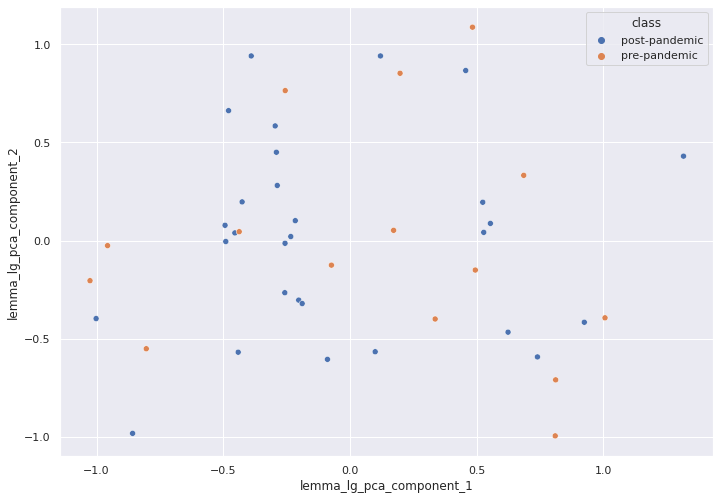

In [37]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_lg_pca_component_1', y='lemma_lg_pca_component_2', hue='class', ax=ax)

Plot showing results color coded by DBSCAN results.

### Cleaned text

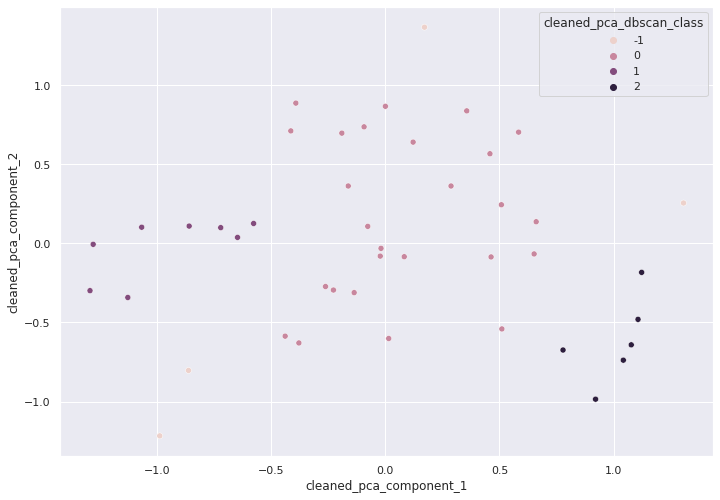

In [38]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='cleaned_pca_component_1', y='cleaned_pca_component_2', hue='cleaned_pca_dbscan_class', ax=ax)

### Lemmatized text

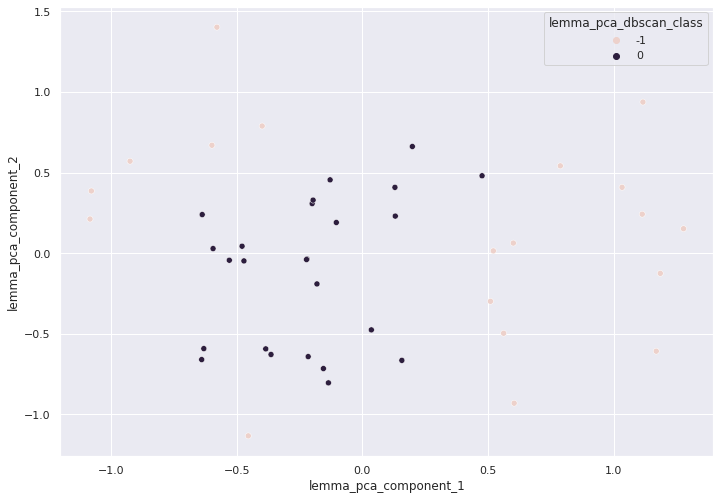

In [39]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_pca_component_1', y='lemma_pca_component_2', hue='lemma_pca_dbscan_class', ax=ax)

### Lemmatized long form

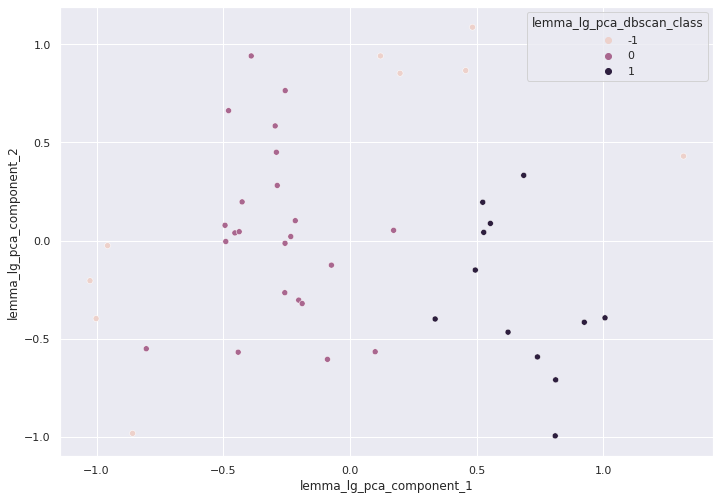

In [40]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_lg_pca_component_1', y='lemma_lg_pca_component_2', hue='lemma_lg_pca_dbscan_class', ax=ax)

## t-SNE Results

Plot showing results color coded by pre and post pandemic publication date.

### Cleaned text

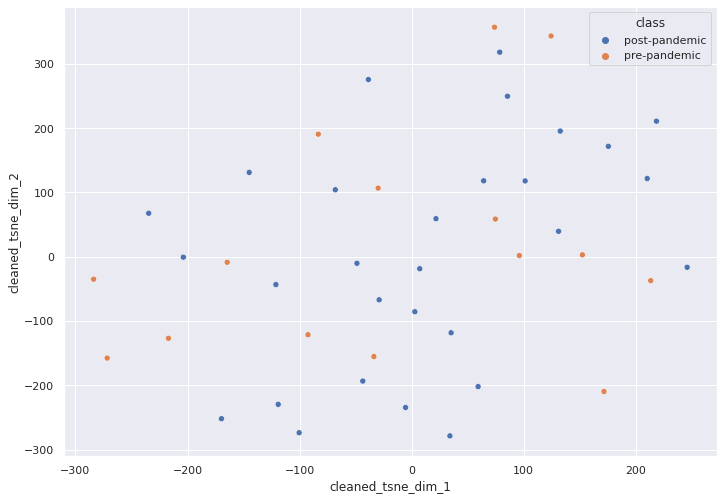

In [41]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='cleaned_tsne_dim_1', y='cleaned_tsne_dim_2', hue='class', ax=ax)

### Lemmatized text

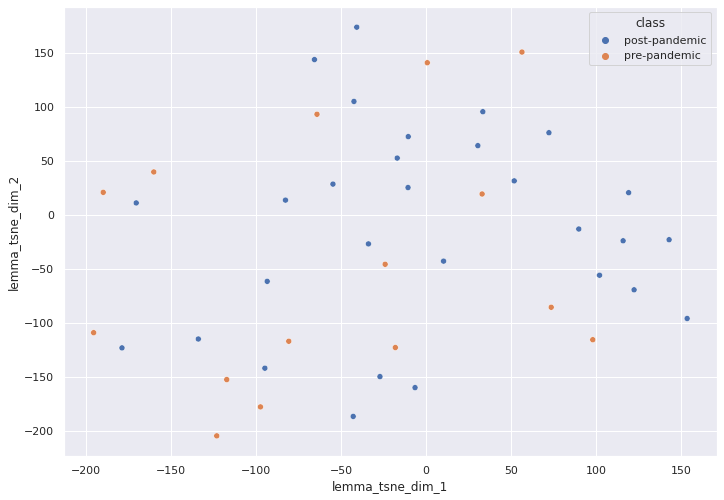

In [42]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_tsne_dim_1', y='lemma_tsne_dim_2', hue='class', ax=ax)

### Lemmatized long form

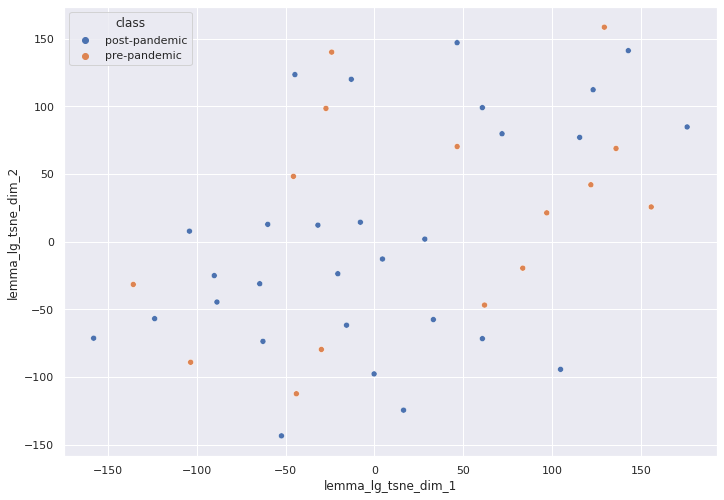

In [43]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_lg_tsne_dim_1', y='lemma_lg_tsne_dim_2', hue='class', ax=ax)

Plot showing results color coded by DBSCAN results.

### Cleaned tetxt

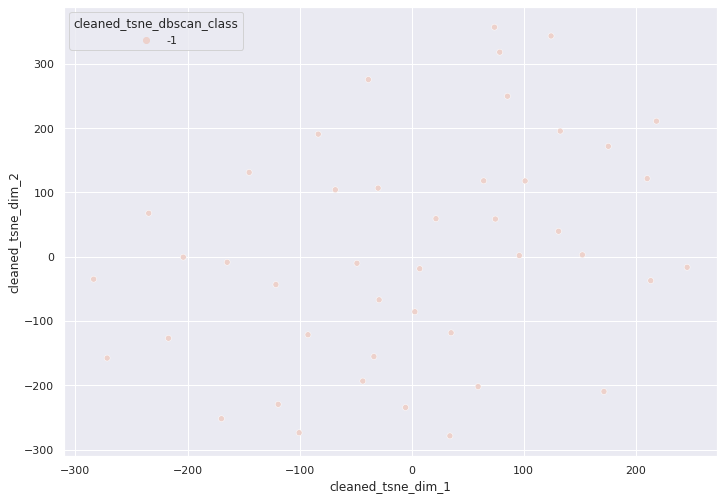

In [44]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='cleaned_tsne_dim_1', y='cleaned_tsne_dim_2', hue='cleaned_tsne_dbscan_class', ax=ax)

### Lemmatized text

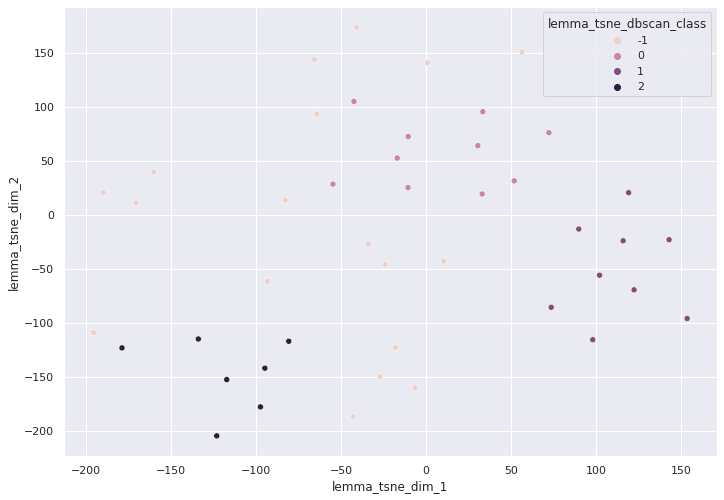

In [45]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_tsne_dim_1', y='lemma_tsne_dim_2', hue='lemma_tsne_dbscan_class', ax=ax)

### Lemmatized long form

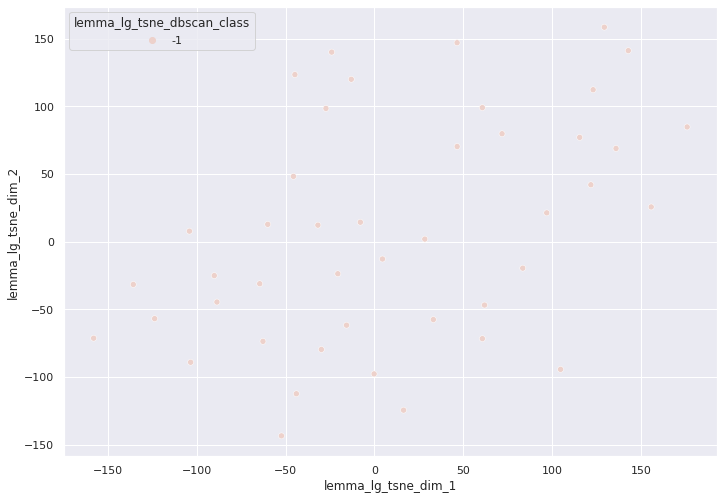

In [46]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data=results_df, x='lemma_lg_tsne_dim_1', y='lemma_lg_tsne_dim_2', hue='lemma_lg_tsne_dbscan_class', ax=ax)